In [1]:
from PIL import Image 
import glob, random, os
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms


In [2]:
RR = transforms.RandomRotation((0, 360))
TT = transforms.ToTensor()
TPIL = transforms.ToPILImage()
myTransforms = transforms.Compose([RR, TT])

# Extract indivdual frames
## 30 fps for 10 seconds

In [20]:
def video_to_frames(video_path, video_name):
    video = cv2.VideoCapture(video_path)
    success, image = video.read()
    count = 0

    while success and count <30*30:
        if count > 20*30: cv2.imwrite(video_name+'/%d.png' % count, image)
        success, image = video.read()
        #print('Reading frame: ', count)
        count+=1
    
video_file = 'test_vid.mp4'

video_name = video_file[:-4]
if not os.path.isdir(video_name): os.mkdir(video_name) 
video_to_frames(video_file, video_name)

len(glob.glob(os.path.join(video_name, '*.png')))

299

# Foveate Images

In [19]:
import subprocess 

frame_dir = 'test_vid/'
frames = glob.glob(os.path.join(frame_dir, '*.png'))

run_foveate = 0
for frame in frames:
    name = frame[len(frame_dir):-4]
    foveate = 'python /home/kp_ai/deepfovia/Image_Foveation_Python/retina_transform.py /home/kp_ai/deepfovia/test_vid/{}.png'.format(name).split(' ')
    if run_foveate==1: subprocess.call(foveate)
    
frames = [int(frame[len(frame_dir):-4]) for frame in frames]
print(min(frames), max(frames))

601 899


In [ ]:
# Example Foveation

In [97]:
rt_img = transforms.ToTensor()(r_img)
ft_img = transforms.ToTensor()(f_img)
torch.cat([rt_img, ft_img]).shape

torch.Size([6, 1080, 1920])

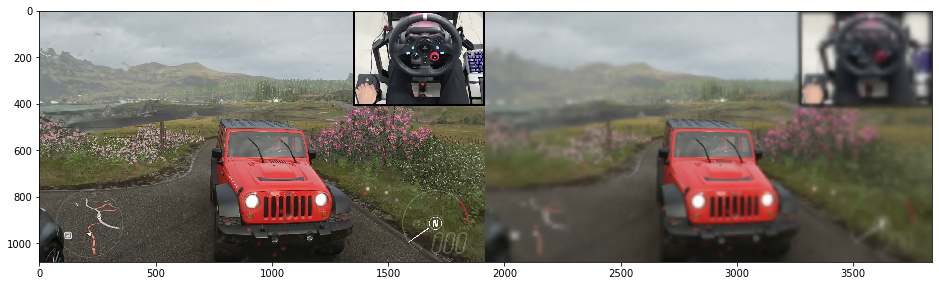

In [89]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

r_img = Image.open("/home/kp_ai/deepfovia/test_vid/750.png")
f_img = Image.open("/home/kp_ai/deepfovia/test_vid/750_RT.jpg")

cat_img = get_concat_h(r_img, f_img)

plt.figure(figsize=(16,8))
plt.imshow(cat_img)

In [2]:
RR = transforms.RandomRotation((0, 360))
TT = transforms.ToTensor()
TPIL = transforms.ToPILImage()
myTransforms = transforms.Compose([TT])

class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 frames_dir='test_vid/', 
                 num_in_frames=4, 
                 transforms=transforms.Compose([transforms.ToTensor()]), 
                 img_size=256):
        
        self.img_size = img_size
        self.num_in_frames = num_in_frames
        self.transforms = transforms
        self.r_frames = glob.glob(os.path.join(frames_dir,'*.png'))
        self.f_frames = glob.glob(os.path.join(frames_dir,'*.jpg'))

    def __getitem__(self, index):
        imgs = []
        for frame in self.f_frames[index:index+self.num_in_frames]:
            imgs.append(transforms.ToTensor()(Image.open(frame).resize((self.img_size,self.img_size))))
        prior = torch.cat(imgs)

        goal = transforms.ToTensor()(Image.open(self.r_frames[index+self.num_in_frames]).resize((self.img_size,self.img_size)))

        return {'X':prior, 'Y':goal}

    def __len__(self):
        return len(self.r_frames)-self.num_in_frames

In [3]:
in_frames = 4
batch_size = 4

train_dataloader = torch.utils.data.DataLoader(VideoDataset(),
                                              batch_size=batch_size,
                                              shuffle=False)

sample_batch = next(iter(train_dataloader))
X = sample_batch['X']
Y = sample_batch['Y']

In [4]:
print('X Shape:', X.shape)
print('Y Shape:', Y.shape)

X Shape: torch.Size([4, 12, 256, 256])
Y Shape: torch.Size([4, 3, 256, 256])


In [5]:
class CNN(torch.nn.Module):
    def __init__(self, nc, nfm, img_size):
        super(CNN, self).__init__()

        exp = int( math.log(img_size)/math.log(2) )

        self.cnn = [nn.Conv2d(nc, nfm, 4, 2, 1),
                   nn.BatchNorm2d(nfm),
                   nn.ReLU()]

        for i in range(exp-3):
          self.cnn += [nn.Conv2d( nfm*(2**i) , nfm*( 2**(i+1) ), 4, 2, 1),
                      nn.BatchNorm2d(nfm*( 2**(i+1) )),
                      nn.ReLU()]

        self.cnn += [nn.Conv2d( nfm*( 2**(exp-3) ) , 1, 4, 1, 0),
                    nn.Sigmoid()]

        self.cnn = nn.Sequential(*self.cnn)

    def forward(self, inputs):
        return self.cnn(inputs)

class ResidualBlock(torch.nn.Module):
    def __init__(self, nfm):
        super(ResidualBlock, self).__init__()

        self.conv_block = nn.Sequential(
          nn.Conv2d(nfm, nfm, 3, 1, 1),
          nn.BatchNorm2d(nfm),
          nn.ReLU(),
          nn.Conv2d(nfm, nfm, 3, 1, 1),
          nn.BatchNorm2d(nfm)
        )

        self.relu = nn.ReLU()

    def forward(self, x):
        result = x + self.conv_block(x)
        out = self.relu(result)
        return out

class ResNet(torch.nn.Module):
    def __init__(self, nfm, layers):
        super(ResNet, self).__init__()

        self.resnet = []
        for _ in range(layers):
            self.resnet += [ResidualBlock(nfm)]

        self.resnet = nn.Sequential(*self.resnet)

    def forward(self, x):
        return self.resnet(x)

### upconv = nn.ConvTranspose2d(nfm*2*2, out_up_nc*2, 4, 2, 1)

class U_Net_Block(torch.nn.Module):
    def __init__(self, submodule, nfm=64, in_frames=None, out_frames=None, outermost=False, innermost=False):
        super(U_Net_Block, self).__init__()

        self.outermost = outermost
        self.innermost = innermost
        self.nfm = nfm
        
        self.hidden = [torch.zeros(4, self.nfm, 128, 128),
                       torch.zeros(4, self.nfm, 64, 64)]

        if outermost:
            in_down_nc = in_frames*3
            out_up_nc = out_frames*3
        else:
            in_down_nc = nfm
            out_up_nc = nfm
        
        downconv = nn.Conv2d(in_down_nc, nfm*2, 4, 2, 1)
        #upconv = nn.ConvTranspose2d(nfm*2*2, out_up_nc, 4, 2, 1)
        # *5 because (2*2): from skip connection + 1 from recurrent input
        upconv = nn.ConvTranspose2d(nfm*4, out_up_nc*2, 4, 2, 1)
        downnorm = nn.BatchNorm2d(nfm*2)
        upnorm = nn.BatchNorm2d(out_up_nc*2)
        relu = nn.ReLU()
        tanh = nn.Tanh()

        if outermost:
            upconv = nn.ConvTranspose2d(128, out_up_nc, 4, 2, 1)
            down = [downconv, downnorm, relu]
            up = [upconv, tanh]
        elif innermost:
            res_nfm = 64
            
            downconv = nn.Conv2d(nfm, res_nfm, 4, 2, 1)
            upconv = nn.ConvTranspose2d(res_nfm, out_up_nc, 4, 2, 1)
            downnorm = nn.BatchNorm2d(res_nfm)
            upnorm = nn.BatchNorm2d(out_up_nc)

            down = [downconv, downnorm, relu]
            up = [upconv, upnorm, relu]
        else:
            downconv = nn.Conv2d(in_down_nc*2, nfm*2, 4, 2, 1)
            down = [downconv, downnorm, relu]
            up = [upconv, upnorm, relu]

        self.u_block = down + [submodule] + up
        self.u_block = nn.Sequential(*self.u_block)
                
    def forward(self, x):
        #print('initial x shape: ', x.shape)
        if self.outermost:
            #print('augmented shape: ', x.shape )
            return self.u_block(x)
        elif not self.innermost:
            if x.shape[2] == 128: 
#                print('PREVIOUS HIDDEN: \n', self.hidden[0])
                old_hidden = self.hidden[0]
                cat_recurrent = torch.cat([self.hidden[0], x], 1)
                cat_feature_layers = torch.cat([x, self.u_block(cat_recurrent)], 1)
                self.hidden = [cat_feature_layers[:, :x.shape[1], :, :], self.hidden[1]]
#                 print('NEW HIDDEN: \n', self.hidden[0])
#                 print('EQUAL', torch.all(torch.eq(old_hidden, self.hidden[0])))
            else: 
                cat_recurrent = torch.cat([self.hidden[1], x], 1)
                cat_feature_layers = torch.cat([x, self.u_block(cat_recurrent)], 1)
                self.hidden = [self.hidden[0], cat_feature_layers[:, :x.shape[1], :, :]]
                
            #print('augmented shape: ', cat_feature_layers.shape )
            #print(self.hidden)
            return cat_feature_layers[:, x.shape[1]:, :, :]
            
        else:
            cat_feature_layers = torch.cat([x, self.u_block(x)], 1)
            #print('augmented shape: ', cat_feature_layers.shape )
            return cat_feature_layers
    
    def _init_hidden(self):
        if torch.cuda.is_available(): self.hidden = [torch.zeros(4, self.nfm, 128, 128).cuda(),
                                                     torch.zeros(4, self.nfm, 64, 64).cuda()]
        else: self.hidden = [torch.zeros(4, self.nfm, 128, 128),
                             torch.zeros(4, self.nfm, 64, 64)]
        

class U_Net(torch.nn.Module):
    def __init__(self, nfm, base_network, in_frames, out_frames):
        super(U_Net, self).__init__()

        # ResNet Feature Maps: Res_Nfm x 16 x 16
        self.unet_in = U_Net_Block(base_network, nfm*4, innermost=True)
        # Unet: nfm*4 x 32 x 32
        self.unet_mid2 = U_Net_Block(self.unet_in, nfm*2)
        # Unet: nfm*2 x 64 x 64
        self.unet_mid1 = U_Net_Block(self.unet_mid2, nfm)
        # Unet: nfm x 128 x 128
        self.unet = U_Net_Block(self.unet_mid1, int(nfm/2), in_frames=in_frames, out_frames=out_frames, outermost=True)
        self._init_hidden()
        # Unet: num_frames x 256 x 256
        self.hidden=[]

    def forward(self, x):
        return self.unet(x)

    def _init_hidden(self):
        self.unet_mid1._init_hidden()
        self.unet_mid2._init_hidden()
        #print('---- HIDDEN STATES ----')
        #for i in self.unet.hidden: print(i.shape)
        #print('-----------------------')

In [129]:
nfm = 64
res_blocks = 4
epochs = 3000

resnet = ResNet(nfm, res_blocks)
my_unet = U_Net(nfm, resnet, in_frames, 1)

y = my_unet(sample_batch['X'])
print(y.shape)

---- HIDDEN STATES ----
torch.Size([4, 32, 128, 128])
torch.Size([4, 32, 64, 64])
-----------------------
torch.Size([4, 3, 256, 256])


In [141]:
a = torch.Tensor(4, 12, 256, 256)
b = torch.Tensor(4, 3, 256, 256)
c = torch.cat([a,b], axis = 1)

discriminator = CNN((in_frames+1)*(3), nfm, 256)
discriminator(c).shape

torch.Size([4, 1, 1, 1])

In [144]:
os=torch.ones(batch_size, 1, 1, 1)
zs=torch.zeros(batch_size, 1, 1, 1)
torch.cat([os,zs]).shape

torch.Size([8, 1, 1, 1])

In [64]:
my_unet._init_hidden()

---- HIDDEN STATES ----
torch.Size([4, 32, 128, 128])
torch.Size([4, 32, 64, 64])
-----------------------


In [135]:
a = torch.Tensor(4, 4, 8, 8)
b = torch.Tensor(4, 4, 8, 8)
torch.cat([a,b], axis = 1).shape

torch.Size([4, 8, 8, 8])

Training Started...
Epoch 0/3000, Batch 0/74, Loss: 0.6209967136383057


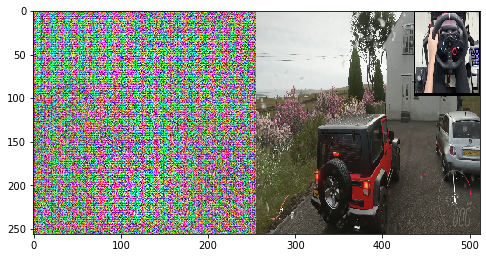

KeyboardInterrupt: 

In [6]:
from IPython.display import clear_output

nfm = 64
res_blocks = 4
epochs = 3000

resnet = ResNet(nfm, res_blocks)
my_unet = U_Net(nfm, resnet, 1, 1)

discriminator = CNN((in_frames+1)*3, nfm, 256)


optimizer = torch.optim.Adam(my_unet.parameters(), lr=0.002)
L_pixel = nn.MSELoss()
L_adv = nn.BCELoss()

D_optim = torch.optim.Adam(discriminator.parameters(), lr=0.02)

print('Training Started...')
for epoch in range(epochs):
    for num, batch in enumerate(train_dataloader):
        if len(batch['X']) == batch_size:
            
            hidden = my_unet._init_hidden()
            optimizer.zero_grad()
            D_optim.zero_grad()
            
            for i in range(0,12,3):
                result = my_unet(sample_batch['X'][:,i:i+3, :, :])
                
            fake_set = torch.cat([sample_batch['X'],result], axis = 1)
            fake_labels = torch.zeros(batch_size, 1, 1, 1)
            
            real_set = torch.cat([sample_batch['X'],sample_batch['Y']], axis = 1)
            real_labels = torch.zeros(batch_size, 1, 1, 1)
            
            fake_real_imgs = torch.cat([fake_set, real_set])
            fake_real_labels = torch.cat([fake_labels, real_labels])
            
            adv_error = L_adv(discriminator(fake_real_imgs), fake_real_labels)
            adv_error.backward(retain_graph=True)
            D_optim.step()
            
            pixel_error = L_pixel(result, sample_batch['Y'])
            #opt_flow_error = L_optflow()
            error = pixel_error# + optflow_error
            error.backward()
            optimizer.step()
            
        if num % 10==0:
            print('Epoch {}/{}, Batch {}/{}, Loss: {}'.format(epoch, epochs, num, len(train_dataloader), error))
            clear_output()
            plt.figure(figsize=(8,5))
            plt.imshow(transforms.ToPILImage()(torch.cat([result[0], batch['Y'][0]], axis=2)))
            plt.show()
            
    print('Epoch {}/{}, Loss: {}'.format(epoch, epochs, error))

In [174]:
plt.show(transforms.ToPILImage()(torch.cat([result[0], batch['Y'][0]], axis=2)))

IMAGE 3


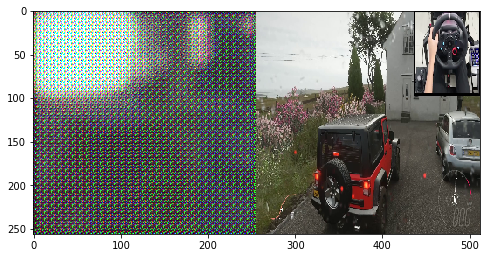

In [10]:


for i in range(result.shape[0]):
    clear_output()
    print('IMAGE', i)

